# Tutorial: Training a Neural Operator (Detailed Guide)

Welcome to the `HyperNOs` training tutorial. This notebook will guide you through training a neural operator using our Unified Training Pipeline.

> **Prerequisites**: Before getting started, ensure you have set up the environment and downloaded the data. Please refer to the [Installation Guide](README.md#installation) in the main README for details.

## What is HyperNOs?
HyperNOs is designed to be a **modular, general-purpose framework** for developing and testing Neural Operators. It decouples:
1.  **Architecture**: The neural network model (e.g., FNO, CNO, DeepONet).
2.  **Data**: The physics problem (e.g., Darcy, Navier-Stokes).
3.  **Training Logic**: The loop handling optimization, checkpointing, and logging.

### Integrating External Libraries
A unique feature of this framework is its ability to seamlessy wrap **external libraries**.
- **Custom Models**: Use our optimized implementations in `architectures/`.
- **Official [`neuraloperator`](https://github.com/neuraloperator/neuraloperator)**: Wrap standard models like `FNO`, `TFNO`, `CODANO`, `UNO`, `RNO`, `LocalNO`, `OTNO` and many others (see `neuralop_lib` examples).
- **[`DeepXDE`](https://github.com/lululxvi/deepxde)**: Wrap physics-informed models like `DeepONet`, `MIONet`, `POD-DeepONet`, `POD-MIONet` (see `deepxde_lib` examples).

This tutorial focuses on our custom implementation of FNO, but the logic remains identical for any other model.

In [6]:
import os
import sys
import torch

# Ensure the 'neural_operators' package is in the path
sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "neural_operators"))

from neural_operators.architectures import FNO
# === MODULARITY NOTE ===
# To use an external library model, you would import it here, e.g.:
# from neuralop.models import TFNO 
# from deepxde.nn import DeepONetCartesianProd

from neural_operators.datasets import NO_load_data_model
from neural_operators.loss_fun import loss_selector
from neural_operators.train import train_fixed_model
from neural_operators.utilities import get_plot_function
from neural_operators.wrappers import wrap_model_builder

## 1. Configuration & Hyperparameters

We explicitly define the hyperparameters below. In a production setting, these might be loaded from JSON files (using `initialize_hyperparameters`), but defining them here makes this notebook self-contained.

These parameters control everything from the `optimizer` behavior to the `architecture` depth.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Explicit Dictionary of Hyperparameters
default_hyper_params = {
    # --- Optimization ---
    "training_samples": 128,
    "val_samples": 64,
    "test_samples": 64,
    "learning_rate": 0.001,
    "epochs": 10, 
    "batch_size": 32,
    "weight_decay": 1e-4,
    "scheduler_step": 10,
    "scheduler_gamma": 0.5,
    "beta": 1,

    # --- Model Architecture (FNO Specific) ---
    "width": 32,
    "modes": 8,
    "n_layers": 2,
    "padding": 10,
    "fno_arc": "Residual",
    "fun_act": "gelu",
    "in_dim": 1,
    "out_dim": 1,
    "fft_norm": None,
    "FourierF": 0,
    "RNN": False,
    "include_grid": 1,
    "weights_norm": "Kaiming",
    "retrain": 4,
    
    # --- Problem Specs ---
    "problem_dim": 2,
    "filename": None 
}

Device: cuda


## 2. The Data Pipeline

`NO_load_data_model` is our universal data loader. It:
1.  **Locates** the HDF5/Mat file for the requested `which_example`.
2.  **Normalizes** inputs and outputs (Gaussian or MinMax).
3.  **Splits** data into Train/Val/Test sets.
4.  **Generates** PyTorch DataLoaders.

This abstraction means you don't need to write custom dataset classes for every new physics problem. In particular we have implemented all the code needed to load all the benchmarks presented in [Convolutional Neural Operators for Robust and Accurate Learning of Partial Differential Equations](https://www.sam.math.ethz.ch/sam_reports/reports_final/reports2023/2023-11.pdf).

In [8]:
# Choose the example
which_example = "darcy"  

# === DATA LOADING ===
example = NO_load_data_model(
    which_example=which_example,
    no_architecture={
        "FourierF": default_hyper_params.get("FourierF", 0),
        "retrain": default_hyper_params.get("retrain", 42),
    },
    batch_size=default_hyper_params["batch_size"],
    training_samples=default_hyper_params["training_samples"],
    filename=(
        default_hyper_params["filename"]
        if "filename" in default_hyper_params
        else None
    ),
)

print(f"Loaded dataset '{which_example}' with {default_hyper_params['training_samples']} training samples.")

📂 File Darcy_64x64_IN.h5 found in /home/max/Desktop/HyperNOs/data
📂 File Darcy_64x64_IN.h5 found in /home/max/Desktop/HyperNOs/data
📂 File Darcy_64x64_IN.h5 found in /home/max/Desktop/HyperNOs/data
Loaded dataset 'darcy' with 128 training samples.


## 3. Modular Model Building & Wrappers

We define a functional interface `builder(config)` that returns an instantiated `nn.Module`. 

### The Wrapper System (`wrap_model_builder`)
Different libraries have different conventions:
- **Channel-First** vs **Channel-Last** tensors.
- **Input shapes** (Grid inputs vs flat coordinate inputs).

The `wrap_model_builder` function solves this. It inspects the `which_example` or suffix (like `_deepxde` or `_neural_operator`) and automatically applies the necessary transformations. This allows `train_fixed_model` to treat a DeepXDE or NeuralOperator model exactly like a native model.

In [9]:
def builder(config):
    # --- MODEL INSTANTIATION ---
    # This is where you can plug in ANY model.
    # Example for official TFNO: 
    # return TFNO(n_modes=(16,16), hidden_channels=32, ...)
    
    return FNO(
        config["problem_dim"],
        config["in_dim"],
        config["width"],
        config["out_dim"],
        config["n_layers"],
        config["modes"],
        config["fun_act"],
        config["weights_norm"],
        config["fno_arc"],
        config["RNN"],
        config["fft_norm"],
        config["padding"],
        device,
        (
            example.output_normalizer
            if ("internal_normalization" in config and config["internal_normalization"])
            else None
        ),
        config["retrain"],
    )

# Apply the wrapper to handle input/output formatting automatically
# See `examples/` folder for more examples
model_builder = wrap_model_builder(builder, which_example)

## 4. Execution

The `train_fixed_model` run loop handles:
- **Optimization**: AdamW, Learning Rate Scheduling.
- **Validation**: Regular checks on test splits.
- **Visualization**: Generating prediction plots (`get_plot_function`).
- **Persistence**: Saving the trained model to disk.

In [10]:
# Choose the loss function to train the model
loss_fn_str = "L2"

# Dataset builder alias for consistency during lazy loading
dataset_builder = lambda config: NO_load_data_model(
    which_example=which_example,
    no_architecture={
        "FourierF": config.get("FourierF", 0),
        "retrain": config.get("retrain", 42),
    },
    batch_size=config["batch_size"],
    training_samples=config["training_samples"],
    filename=config["filename"] if "filename" in config else None,
)

# Loss function selector
loss_fn = loss_selector(
    loss_fn_str=loss_fn_str,
    problem_dim=default_hyper_params["problem_dim"],
    beta=default_hyper_params["beta"],
)

experiment_name = f"FNO_Notebook/{which_example}_comprehensive_tutorial"

train_fixed_model(
    default_hyper_params,
    model_builder,
    dataset_builder,
    loss_fn,
    experiment_name,
    get_plot_function(which_example, "input"),
    get_plot_function(which_example, "output"),
    full_validation=True,
)

📂 File Darcy_64x64_IN.h5 found in /home/max/Desktop/HyperNOs/data
📂 File Darcy_64x64_IN.h5 found in /home/max/Desktop/HyperNOs/data
📂 File Darcy_64x64_IN.h5 found in /home/max/Desktop/HyperNOs/data
PyTorch compilation enabled for better performance
No wrapper defined for darcy, returning the original model

🤖 Model Summary:
  📊 Total Parameters: 535,393
  💾Total Model Size: 4,238,724 bytes (4.04 MB)

🚀 Training Progress 🚀


Epoch    0 : [Time : 0.09  , Batch:   4 , Train loss (in progress): 0.9732 🔥]

Epoch    0 : [Time : 0.22  , Train loss: 0.8196  | Test rel. L¹: 0.8098  | Test rel. L²: 0.8205  | Test rel. semi-H¹: 1.3388  | Test rel. H¹: 0.8783 ]
Epoch    1 : [Time : 0.19  , Train loss: 0.4830  | Test rel. L¹: 0.4404  | Test rel. L²: 0.4841  | Test rel. semi-H¹: 2.2613  | Test rel. H¹: 0.8115 ]
Epoch    2 : [Time : 0.19  , Train loss: 0.3202  | Test rel. L¹: 0.2728  | Test rel. L²: 0.3179  | Test rel. semi-H¹: 3.8926  | Test rel. H¹: 1.1826 ]
Epoch    3 : [Time : 0.19  , Train loss: 0.2912  | Test rel. L¹: 0.2490  | Test rel. L²: 0.2913  | Test rel. semi-H¹: 3.1298  | Test rel. H¹: 0.9623 ]
Epoch    4 : [Time : 0.19  , Train loss: 0.2301  | Test rel. L¹: 0.2008  | Test rel. L²: 0.2309  | Test rel. semi-H¹: 1.8648  | Test rel. H¹: 0.5955 ]
Epoch    5 : [Time : 0.19  , Train loss: 0.2293  | Test rel. L¹: 0.2018  | Test rel. L²: 0.2294  | Test rel. semi-H¹: 1.4479  | Test rel. H¹: 0.4853 ]
Epoch    6 : [Time : 0.19  , Train loss: 0.1677  | Test rel. L¹: 0.1431  | Test rel. L²: 0.173

## 5. Visualizing Results with TensorBoard

You can monitor the training progress and compare different runs using TensorBoard. Run the cell below to verify the results of the training.

In [13]:
%load_ext tensorboard
# The logs are saved in the specific experiment directory
log_dir = f"../tests/{experiment_name}"
%tensorboard --logdir $log_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## 6. Model Recovery & Verification

After training, you might want to load the best saved model for inference or further analysis. Here is how you can load the model we just trained and visualize a prediction.

Loading model from: ../tests/FNO_Notebook/darcy_comprehensive_tutorial/model_FNO_tutorial_Darcy.tar
PyTorch compilation enabled for better performance
No wrapper defined for darcy, returning the original model
Model loaded successfully!


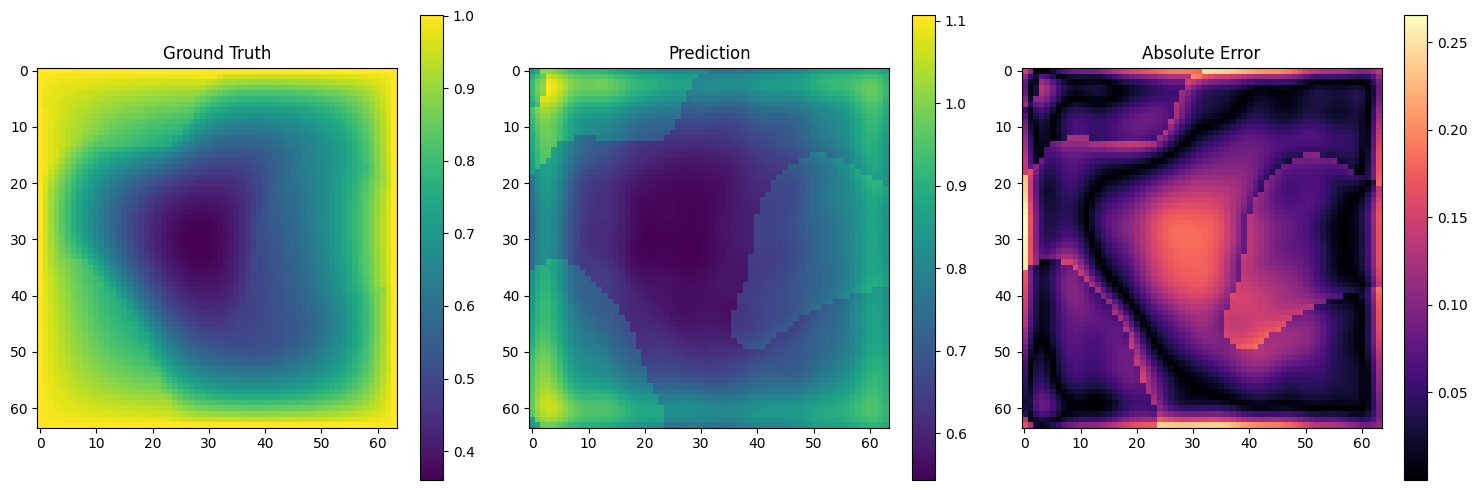

In [14]:
import matplotlib.pyplot as plt

# 1. Identify the saved model file
experiment_dir = f"../tests/{experiment_name}"
# Find the file starting with "model_"
model_files = [f for f in os.listdir(experiment_dir) if f.startswith("model_")]
if not model_files:
    raise FileNotFoundError(f"No model file found in {experiment_dir}")
model_path = os.path.join(experiment_dir, model_files[0])
print(f"Loading model from: {model_path}")

# 2. Instantiate a fresh model
# We use the same builder and hyperparameters.
loaded_model = model_builder(default_hyper_params).to(device)

# 3. Load the state dictionary
checkpoint = torch.load(model_path, map_location=device)
loaded_model.load_state_dict(checkpoint["state_dict"])
print("Model loaded successfully!")

# 4. Run Inference on a Test Sample
loaded_model.eval()
test_loader = example.test_loader
input_batch, truth_batch = next(iter(test_loader))
input_batch = input_batch.to(device)
truth_batch = truth_batch.to(device)

with torch.no_grad():
    prediction = loaded_model(input_batch)

# 5. Visualize (First sample in batch)
sample_idx = 0
# Squeeze to remove channel dim if it's 1, for plotting
input_img = input_batch[sample_idx, 0].cpu().numpy()
truth_img = truth_batch[sample_idx].cpu().numpy().squeeze()
pred_img = prediction[sample_idx].cpu().numpy().squeeze()
error_img = abs(truth_img - pred_img)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im0 = axes[0].imshow(truth_img, cmap='viridis')
axes[0].set_title("Ground Truth")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(pred_img, cmap='viridis')
axes[1].set_title("Prediction")
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(error_img, cmap='magma')
axes[2].set_title("Absolute Error")
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()